# SST Bias Analysis

* Created on 2024 Mar 7
* Will use similar methods to the **Compare_SST** and the Static_Features/**Estimate_SST_impact** analyses
* Will be AWS data-driven

In [1]:
#---Cloud search libraries
import s3fs
import requests
import fnmatch

#---Data libraries
import numpy as np
import xarray as xr
import random

#---Plotting libraries
import matplotlib.pyplot as plt

**Import the Model NLCT data for the false low cloud index:**
* this is calculated in ../Model/Model_NLCT.ipynb
* the model estimates the background emission in 11.2-3.9um

In [2]:
model_filename = 'model_btd_georgesbank_2023090706z.npy'
model_nlct = np.load('../Model/'+model_filename)

In [3]:
#--- Creating datetime string
year = model_filename[22:26]
month = model_filename[26:28]
day = model_filename[28:30]
hour = model_filename[31:32]

model_dt = year + "-" + month + "-" + day + " " + hour +":00 UTC"
print(model_dt)

2023-09-07 6:00 UTC


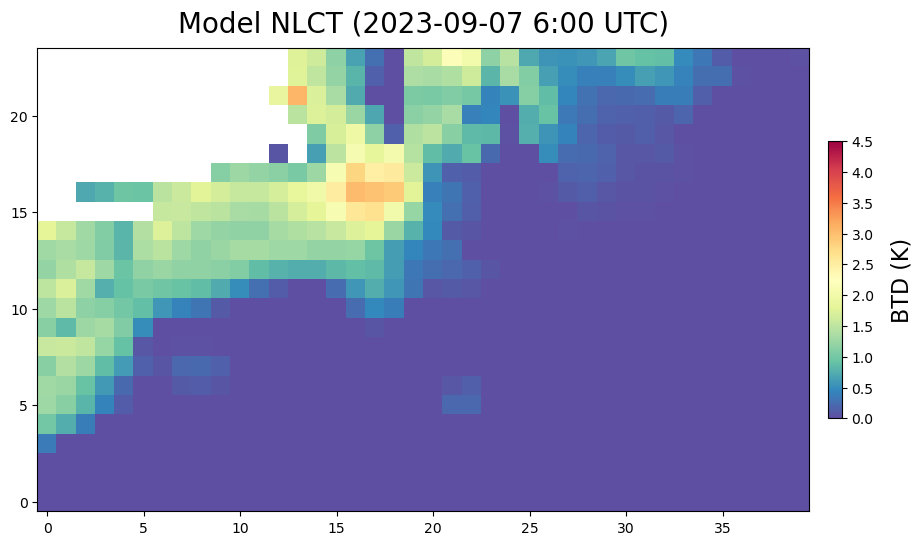

In [4]:
fig,ax=plt.subplots(1, figsize=(12,12))
cmap = plt.cm.Spectral_r

img=ax.imshow(model_nlct, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Model NLCT ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('BTD (K)', fontsize=16, labelpad=12)

**Load the SST data for the same day:**

* Using Optimally Interpolated V2.1 SST AVHRR
* https://www.ncei.noaa.gov/thredds/catalog/OisstBase/NetCDF/V2.1/AVHRR/catalog.html
* downloaded this example manually
* also used in Estimate_SST_impact
--------------------------------------

* Another option is GHRSST
* https://www.ghrsst.org
* temperature sensors on satellites, drifting and moored buoys, ships, Argo floats, gliders, marine mammals, for example seals, and ocean reference stations (so might be too good, for our purposes)
* this data saved in Compare_SST
--------------------------------------
 
* this should be converted to AWS-driven, if I find a suitable product on there

In [5]:
date = year+month+day
print("date:", date)

date: 20230907


In [6]:
sst_path = "OI_SST/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_path)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

Crop SST using the same range as in Model/Model_NLCT:

In [7]:
#---Find some way to sync up these crops
#---Custom
min_lon = -74
min_lat = 37
max_lon = -64
max_lat = 43

#---Custom (zoomed in)
# min_lon = -72
# min_lat = 39
# max_lon = -67
# max_lat = 43

#--- Adjustment for 360 degree longitudes
max_lon_360 = max_lon + 360
min_lon_360 = min_lon + 360

In [8]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon_360,max_lon_360))

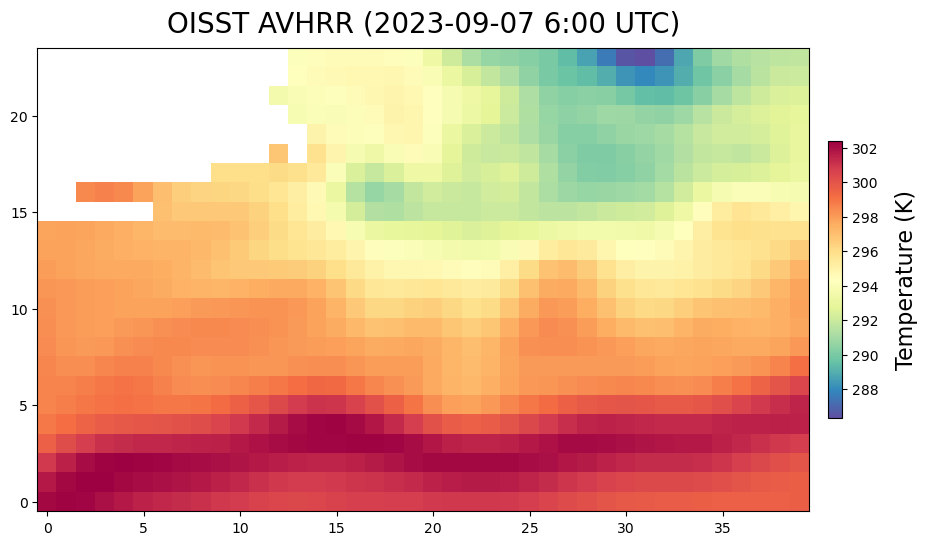

In [9]:
fig,ax=plt.subplots(1, figsize=(12,12))
cmap = plt.cm.Spectral_r

img=ax.imshow(sst_ds.sst, cmap='Spectral_r', origin='lower')
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('OISST AVHRR ('+model_dt+')', fontsize=20, pad=12)
clb.set_label('Temperature (K)', fontsize=16, labelpad=12)

**Compare the SST and the Model NLCT:**

In [10]:
print("model NLCT shape:", model_nlct.shape)
print("SST shape:", sst_ds.sst.shape)

model NLCT shape: (24, 40)
SST shape: (24, 40)


Setting a threshold for BTD that would trigger false low cloud masking: 

In [11]:
flc_threshold_btd = 2.5

#--- Returns indices as y,x 
mask_indices = np.where(model_nlct > flc_threshold_btd)

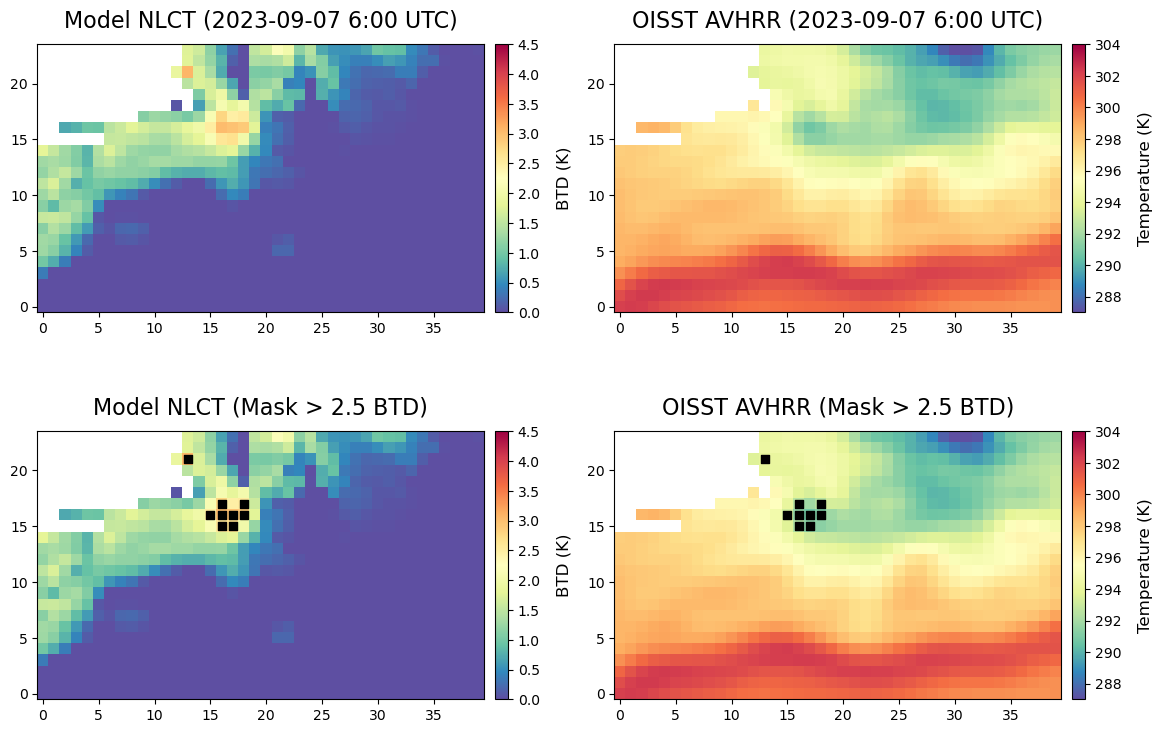

In [12]:
fig,ax=plt.subplots(2, 2, figsize=(12,8))
cmap = plt.cm.Spectral_r
cbar_size = 0.7
black_mask_size = 40

img_model_nlct=ax[0,0].imshow(model_nlct, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
clb0=plt.colorbar(img_model_nlct, shrink=cbar_size, pad=0.02, ax=ax[0,0])
ax[0,0].set_title('Model NLCT ('+model_dt+')', fontsize=16, pad=12)
clb0.set_label('BTD (K)', fontsize=12, labelpad=12)

img_sst=ax[0,1].imshow(sst_ds.sst, cmap='Spectral_r', origin='lower', vmin=287, vmax=304)
clb1=plt.colorbar(img_sst, shrink=cbar_size, pad=0.02, ax=ax[0,1])
ax[0,1].set_title('OISST AVHRR ('+model_dt+')', fontsize=16, pad=12)
clb1.set_label('Temperature (K)', fontsize=12, labelpad=12)

img_model_nlct=ax[1,0].imshow(model_nlct, cmap='Spectral_r', origin='lower', vmin=0, vmax=4.5)
mask_model_nlct = ax[1,0].scatter(mask_indices[1], mask_indices[0], color='black', marker='s', s=black_mask_size)
clb3=plt.colorbar(img_model_nlct, shrink=cbar_size, pad=0.02, ax=ax[1,0])
ax[1,0].set_title('Model NLCT (Mask > 2.5 BTD)', fontsize=16, pad=12)
clb3.set_label('BTD (K)', fontsize=12, labelpad=12)

img_sst=ax[1,1].imshow(sst_ds.sst, cmap='Spectral_r', origin='lower', vmin=287, vmax=304)
mask_sst = ax[1,1].scatter(mask_indices[1], mask_indices[0], color='black', marker='s', s=black_mask_size)
clb4=plt.colorbar(img_sst, shrink=cbar_size, pad=0.02, ax=ax[1,1])
ax[1,1].set_title('OISST AVHRR (Mask > 2.5 BTD)', fontsize=16, pad=12)
clb4.set_label('Temperature (K)', fontsize=12, labelpad=12)

fig.tight_layout()
fig.show()

In [13]:
sum_sst_masked = 0
count_masked = 0

for j in range(model_nlct.shape[1]):  # Loop over columns
    for i in range(model_nlct.shape[0]):  # Loop over rows
        if model_nlct[i][j] > flc_threshold_btd:
            sum_sst_masked += sst_ds.sst[i][j].values
            count_masked += 1

#--- Flattened the 2d array in order to remove nans more easily            
flat_sst = np.array(sst_ds.sst).flatten()
flat_sst = flat_sst[~np.isnan(flat_sst)]

print("total masked sst:", sum_sst_masked)
print("total filled in sst:", np.sum(flat_sst))
print("number of masked points:", count_masked)
print("number of filled in points:", len(flat_sst))
print("average of masked:", round(sum_sst_masked/count_masked, 1))
print("average sst filled in:", round(np.mean(flat_sst),1))
average_sst_masked = (np.sum(flat_sst) - sum_sst_masked) / (len(flat_sst)-count_masked)
print("average sst without masked:", average_sst_masked)
print("bias caused by flc masking:", average_sst_masked - np.mean(flat_sst))

total masked sst: 2628.8399353027344
total filled in sst: 256676.94
number of masked points: 9
number of filled in points: 865
average of masked: 292.1
average sst filled in: 296.7
average sst without masked: 296.78516070642206
bias caused by flc masking: 0.048802063843936594


**Bootstrap testing for significance**

Testing the null hypothesis that masked SST and SST are from the same distribution:

In [14]:
N = count_masked
num_of_resamples = 10000
sst_means = []

for i in range(num_of_resamples):
  sst_sample = random.sample(list(flat_sst), N)
  sst_means.append(np.mean(sst_sample))

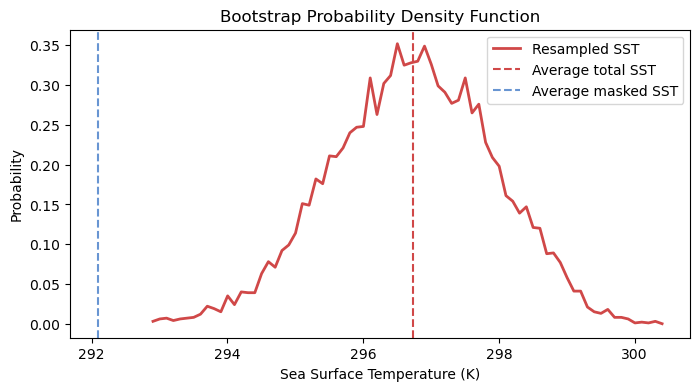

In [15]:
#---Set bins
xinc = 0.1
xbins = np.arange(np.min(sst_means), np.max(sst_means), xinc)

h_P = np.histogram(sst_means,xbins)
x_arr = h_P[1][:-1]
fvals_P = h_P[0].astype(float)/(np.size(sst_means)*xinc)

#---Make figure
fig, ax = plt.subplots(1, figsize=(8,4))

ax.set_xlabel('Sea Surface Temperature (K)')
ax.set_ylabel('Probability')
ax.set_title('Bootstrap Probability Density Function')

ax.plot(x_arr+xinc/2, fvals_P, color='#D04848', label='Resampled SST', linewidth=2)
ax.axvline(x=np.mean(flat_sst).round(2), color='#D04848', linestyle='--', label='Average total SST')
ax.axvline(x=round(sum_sst_masked/count_masked, 1), color='#6895D2', linestyle='--', label='Average masked SST')
ax.legend()

#plt.savefig('.png', dpi = 300)
plt.show()

Testing the null hypothesis that total SST and SST without masked are from the same distribution:

In [16]:
N = (len(flat_sst)-count_masked)
num_of_resamples = 10000
sst_means = []

for i in range(num_of_resamples):
  sst_sample = random.sample(list(flat_sst), N)
  sst_means.append(np.mean(sst_sample))

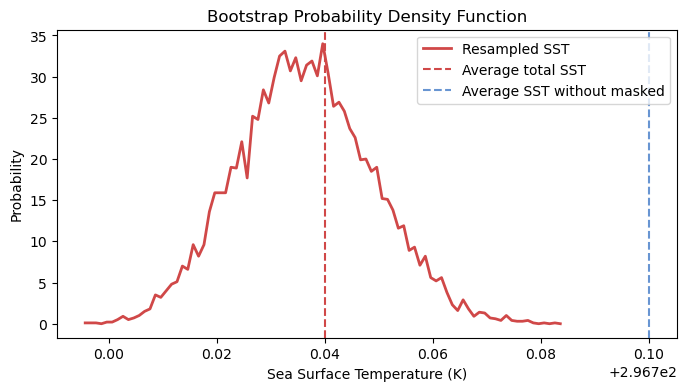

In [17]:
#---Set bins
xinc = 0.001
xbins = np.arange(np.min(sst_means), np.max(sst_means), xinc)

h_P = np.histogram(sst_means,xbins)
x_arr = h_P[1][:-1]
fvals_P = h_P[0].astype(float)/(np.size(sst_means)*xinc)

#---Make figure
fig, ax = plt.subplots(1, figsize=(8,4))

ax.set_xlabel('Sea Surface Temperature (K)')
ax.set_ylabel('Probability')
ax.set_title('Bootstrap Probability Density Function')

ax.plot(x_arr+xinc/2, fvals_P, color='#D04848', label='Resampled SST', linewidth=2)
ax.axvline(x=np.mean(flat_sst).round(2), color='#D04848', linestyle='--', label='Average total SST')
ax.axvline(x=round(average_sst_masked, 1), color='#6895D2', linestyle='--', label='Average SST without masked')
ax.legend()

#plt.savefig('.png', dpi = 300)
plt.show()